In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import time
import math
import numpy as np
import pylab as plt

In [2]:
mnist = input_data.read_data_sets("MNIST_data",one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
#普通神经元weights
def weight_variable(shape,name):
    initial = tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(initial,name=name)
#普通神经元bias
def bias_variable(shape,name):
    initial = tf.constant(0.1,shape=shape)
    return tf.Variable(initial,name=name)
#卷积层
def conv2d(x,W, xStride = 1,yStride = 1,name="conv2d"):
    strides=[1,xStride,yStride,1]#斜角阵，对角线为1
    paddingMode = "SAME"  # "SAME" or "VALID"
    return tf.nn.conv2d(x,W,strides,padding=paddingMode,name=name)  #conv2d，卷积的是单色图，没有channel的
#池化层
def max_pool(x,windowWidth = 2,windowHeight = 2,xStride = 2,yStride = 2,name="maxpool"):
    windowSize = [1,windowWidth,windowHeight,1]#斜角阵，对角线为1
    strides=[1,xStride,yStride,1]#斜角阵，对角线为1
    paddingMode = "SAME"  # "SAME" or "VALID"
    return tf.nn.max_pool(x,ksize=windowSize,strides=strides,padding=paddingMode,name=name)
def convLayer(input,scope,wWid,wHei,dimens,coreNum):
    with tf.name_scope(scope,"ConvLayer"):
        weight_con = weight_variable([wWid,wHei,dimens,coreNum],"conv_weights") #卷积核窗口大小5*5，1是维度，32个卷积核
        bians_con = bias_variable([coreNum],"conv_bians")
        param_con = conv2d(input,weight_con)+bians_con
        output_con = tf.nn.relu(param_con)
        return output_con
def poolLayer(input,scope,windowWidth = 2,windowHeight = 2,xStride = 2,yStride = 2):
    with tf.name_scope(scope,"PoolLayer"):
        return max_pool(input)
def denseLayer(input,scope,activationFunc,sc,sn):
    with tf.name_scope(scope,"DenseLayer"):
        weight = weight_variable([sc,sn],"dense_weights")
        bians = bias_variable([sn],"dense_bians")
        param = tf.matmul(input,weight)+bians
        param.tensor_name="output"
        if activationFunc != None:
            return activationFunc(param)
        else:
            return param

In [11]:
tf.reset_default_graph()

batch_size = 1024
n_batch = math.ceil(mnist.train.num_examples / batch_size)
max_steps = 30

with tf.name_scope("Input"):
    x = tf.placeholder(tf.float32,[None,784],name='x') #28*28=784
    y = tf.placeholder(tf.float32,[None,10],name='y') #28*28=784

#把784像素向量转换成28*28的Image,[batch,height,width,channel]
x_image = tf.reshape(x,[-1,28,28,1])

#卷积层1 16核
conv1_output = convLayer(x_image,"ConvLayer1_16",5,5,1,16)
print(conv1_output.get_shape())

#Pool层1  输出14*14  16张
pool1_output = poolLayer(conv1_output,"PoolLayer1_16")
print(pool1_output.get_shape())

#卷积层2 32核
conv2_output = convLayer(pool1_output,"ConvLayer2_32",5,5,16,32)
print(conv2_output.get_shape())

#Pool层2 输出7*7  32张
pool2_output = poolLayer(conv2_output,"PoolLayer2_32")
print(pool2_output.get_shape())

#求取输出结果向量维度
image_vec_dimens = 7*7*32

#向量扁平化pool层输出
image_output = tf.reshape(pool2_output,[-1,image_vec_dimens],name='reshape')

#全连接神经网络
dense_layer1_output = denseLayer(image_output,"DNN_hidden_Layer",tf.nn.relu,image_vec_dimens,784)

#输出层
logits = denseLayer(dense_layer1_output,"Output",None,784,10)

prediction = tf.nn.softmax(logits,name="prediction")

#loss & accuracy
with tf.name_scope("Metrics"):
    loss = tf.reduce_mean(-tf.reduce_sum(y*tf.log((tf.clip_by_value(prediction, 1e-6, 1)))))
    tf.summary.scalar("Loss",loss)
    predictionIndex = tf.argmax(prediction,1)
    realIndex = tf.argmax(y,1)
    correctBools = tf.equal(predictionIndex,realIndex)
    accuracy = tf.reduce_mean(tf.cast(correctBools,tf.float32))
    tf.summary.scalar("Accuracy",accuracy)
    global_step = tf.Variable(0,trainable=False,name="global_step")

#train
with tf.name_scope("Train"):
    learning_rate = tf.train.exponential_decay(0.001,global_step,100,0.95,True)
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss,global_step=global_step)

summaryMerge = tf.summary.merge_all()

(?, 28, 28, 16)
(?, 14, 14, 16)
(?, 14, 14, 32)
(?, 7, 7, 32)


In [12]:
trainlog_path = "./logs/train/"
testlog_path= "./logs/test/"

saver = tf.train.Saver()

#用来保存网络模型
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    with tf.summary.FileWriter(trainlog_path,sess.graph) as trainWriter:
        with tf.summary.FileWriter(testlog_path,sess.graph) as testWriter:
            startClock = time.perf_counter()
            print("Start Train.")
            for epoch in range(max_steps):
                startEpochTime = time.perf_counter()
                for batch in range(n_batch):
                    steps = epoch * n_batch + batch
                    batch_xs,batch_ys = mnist.train.next_batch(batch_size)
                    trainResult,summary = sess.run([train_step,summaryMerge],feed_dict={x:batch_xs,y:batch_ys})
                    trainWriter.add_summary(summary,steps)
                    batch_xs,batch_ys = mnist.test.next_batch(batch_size)
                    summary = sess.run(summaryMerge,feed_dict={x:batch_xs,y:batch_ys})
                    testWriter.add_summary(summary,steps)
                acc,lr = sess.run([accuracy,learning_rate],feed_dict={x:mnist.test.images,y:mnist.test.labels})
                print("Iter = {0}, Testing Accuracy = {1},  TrainTime = {2}   Learning_Rate = {3}".format(epoch,acc,time.perf_counter() - startEpochTime,lr))
            print("End Train.   Use Time = ",time.perf_counter() - startClock)
            saver.save(sess,"./ckpt/cnn-mnist.ckpt",steps)

Start Train.
Iter = 0, Testing Accuracy = 0.9528999924659729,  TrainTime = 2.2155163090000087   Learning_Rate = 0.0010000000474974513
Iter = 1, Testing Accuracy = 0.9753999710083008,  TrainTime = 2.0322268639999947   Learning_Rate = 0.0009499999578110874
Iter = 2, Testing Accuracy = 0.9797999858856201,  TrainTime = 2.0600124869999945   Learning_Rate = 0.0009499999578110874
Iter = 3, Testing Accuracy = 0.9847000241279602,  TrainTime = 2.035605944999986   Learning_Rate = 0.0009024999453686178
Iter = 4, Testing Accuracy = 0.9873999953269958,  TrainTime = 2.065938349000021   Learning_Rate = 0.0009024999453686178
Iter = 5, Testing Accuracy = 0.9868999719619751,  TrainTime = 2.0422340030000328   Learning_Rate = 0.0008573749219067395
Iter = 6, Testing Accuracy = 0.9890000224113464,  TrainTime = 2.0691855229999874   Learning_Rate = 0.0008573749219067395
Iter = 7, Testing Accuracy = 0.9882000088691711,  TrainTime = 2.0411667360000365   Learning_Rate = 0.0008145062020048499
Iter = 8, Testing Acc

In [13]:
def image_compose(datas,rows,cols,weight,height):
    rows_data=[]    
    for y in range(0, rows):
        one_rows_data = []
        for x in range(0, cols):
            image_data = datas[y*cols+x]
            data_w = image_data.shape[1]
            data_h = image_data.shape[0]
            if data_w != weight or data_h !=height:
                new_data = np.zeros((height,weight))
                new_data[0:data_h,0:data_w] = image_data
                image_data = new_data
            one_rows_data.append(image_data)
        rows_data.append(np.concatenate(one_rows_data,axis=1))
    data = np.concatenate(rows_data,axis=0)
    return data

def sample_test(sample_num,rows,datas,labels,image_width,image_height,seed):
    cols = math.ceil(sample_num/rows)
    nsd = np.random.RandomState(seed)
    test_lens = len(datas)
    index_samples = nsd.choice(test_lens,sample_num,replace=False)
    X_sample = datas[index_samples]
    X_sample_image = X_sample.reshape((-1,image_height,image_width))
    Y_sample = labels[index_samples]
    images = image_compose(X_sample_image,rows,cols,image_height,image_width)
    return X_sample,Y_sample,images,cols

In [14]:
#常量定义
image_rows=10
CELL_WIDTH = 28
CELL_HEIGHT = 28
x_sample,y_sample,images,image_cols = sample_test(100,image_rows,mnist.test.images,mnist.test.labels,CELL_WIDTH,CELL_HEIGHT,2000)

### 不restore直接用Session run

Accuracy =  0.11


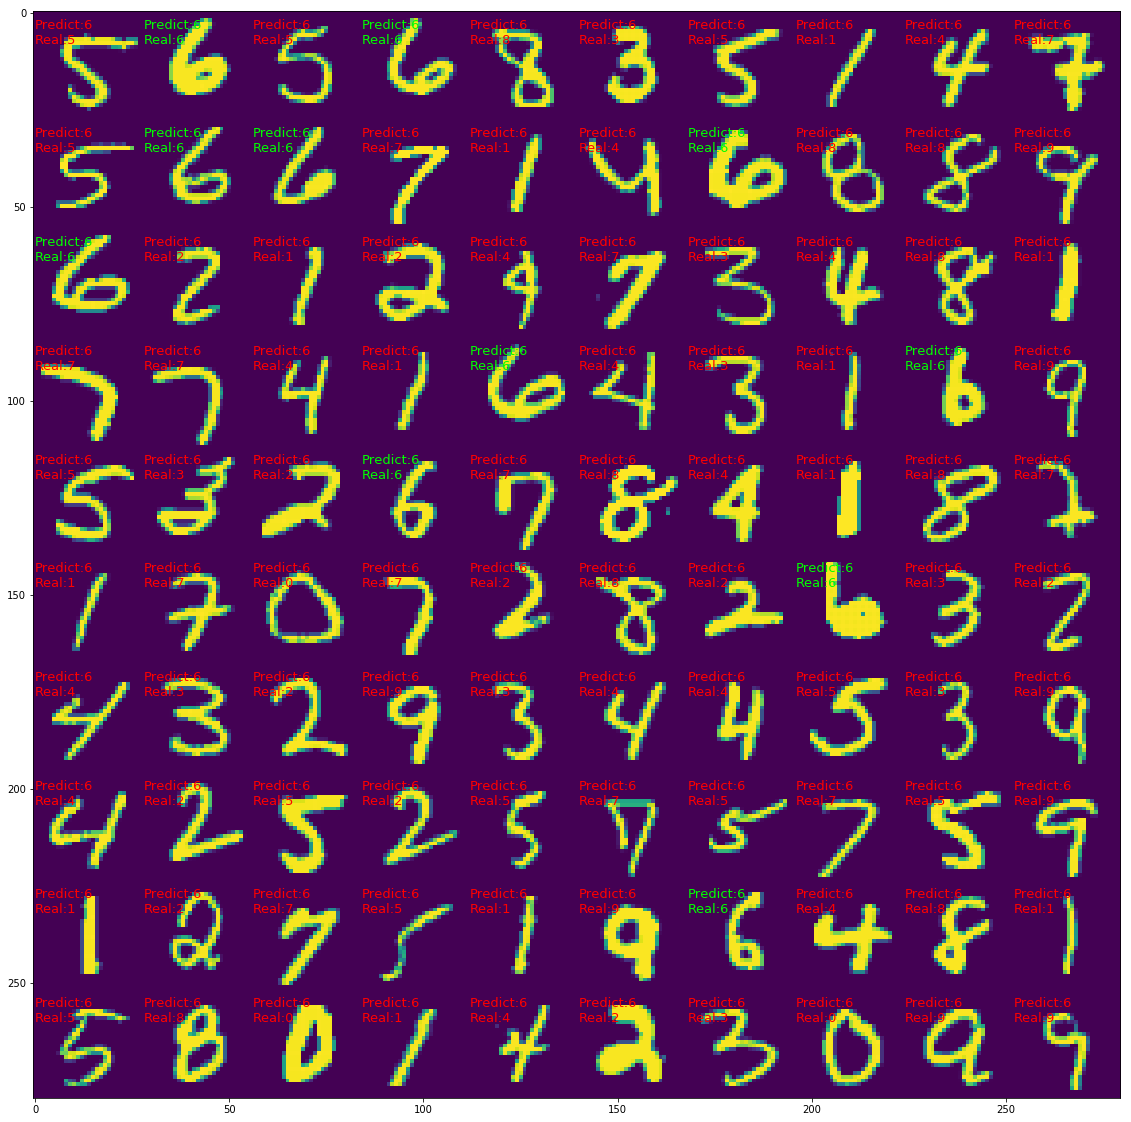

In [15]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    plt.figure(figsize=(20,20))
    plt.imshow(images)
    
    y_sample_predict = sess.run(prediction,feed_dict={x:x_sample})
    sample_predicts = np.argmax(y_sample_predict,axis=1)
    sample_labels = np.argmax(y_sample,axis=1)

    result_v = sample_predicts == sample_labels
    correct_count = len(result_v[result_v==True])
    print("Accuracy = ",correct_count/len(result_v))

    for row in range(image_rows):
        for col in range(image_cols):
            index = row * image_cols +col
            pre = sample_predicts[index]
            label = sample_labels[index]
            label_color = "#00ff00ff" if result_v[index] else "red"
            plt.text(col*CELL_WIDTH,row*CELL_HEIGHT+8,"Predict:{}\nReal:{}".format(pre,label),color=label_color,fontsize=13)
    plt.show()

### 使用restore加载存档

INFO:tensorflow:Restoring parameters from ./ckpt/cnn-mnist.ckpt-1619
Accuracy =  0.99


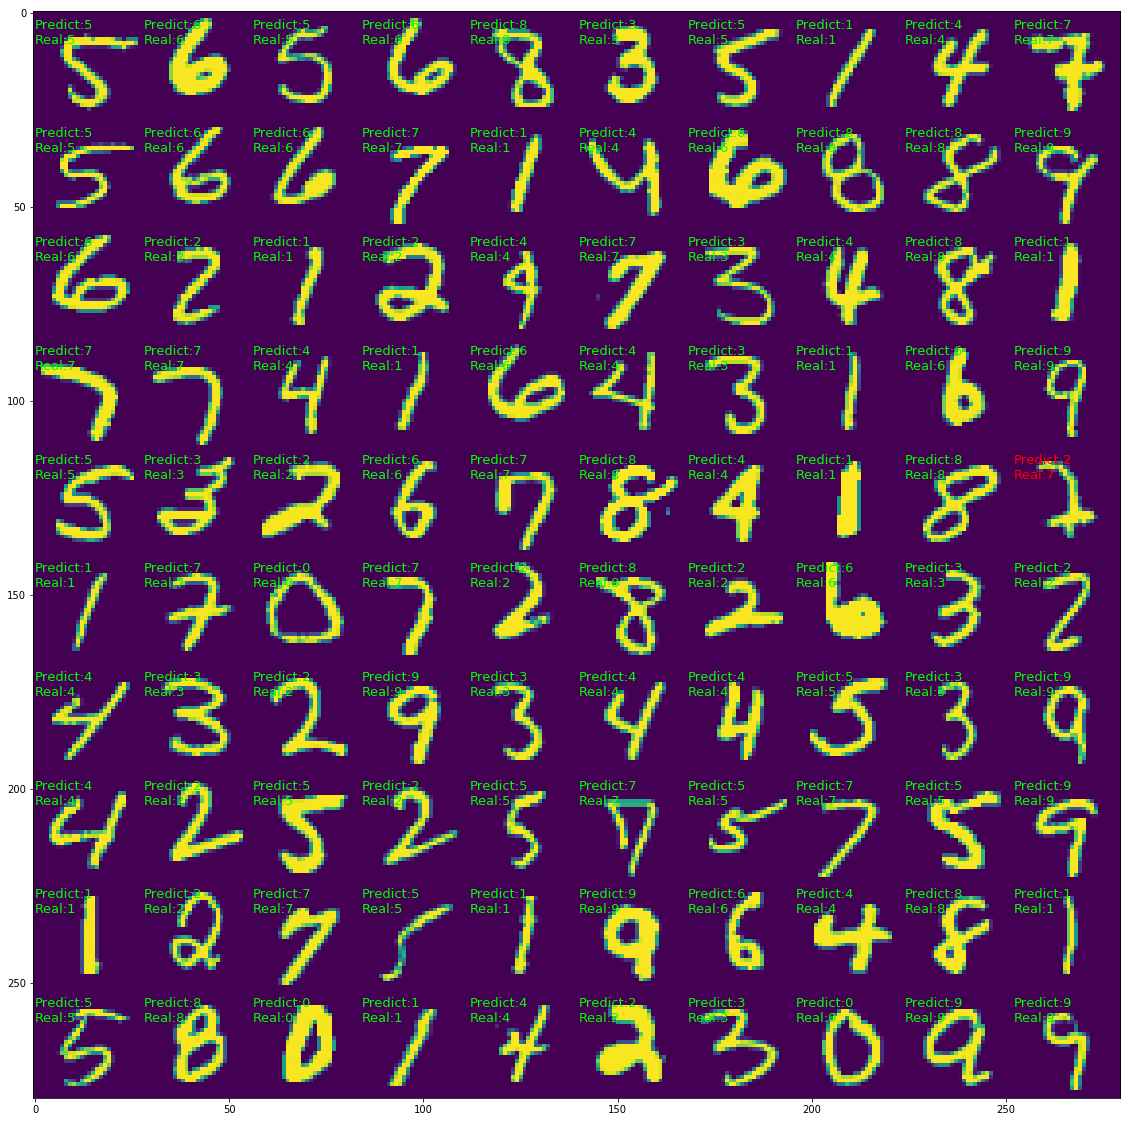

In [17]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    last_saver = tf.train.latest_checkpoint("./ckpt/")
    saver.restore(sess,last_saver)               #需要放在global_variables_initializer后面
    plt.figure(figsize=(20,20))
    plt.imshow(images)
    
    y_sample_predict = sess.run(prediction,feed_dict={x:x_sample})
    sample_predicts = np.argmax(y_sample_predict,axis=1)
    sample_labels = np.argmax(y_sample,axis=1)

    result_v = sample_predicts == sample_labels
    correct_count = len(result_v[result_v==True])
    print("Accuracy = ",correct_count/len(result_v))

    for row in range(image_rows):
        for col in range(image_cols):
            index = row * image_cols +col
            pre = sample_predicts[index]
            label = sample_labels[index]
            label_color = "#00ff00ff" if result_v[index] else "red"
            plt.text(col*CELL_WIDTH,row*CELL_HEIGHT+8,"Predict:{}\nReal:{}".format(pre,label),color=label_color,fontsize=13)
    plt.show()